In [1]:
using Revise, NeuralNetworkAnalysis, JLD2, DifferentialEquations
const NNA = NeuralNetworkAnalysis
const RA = ReachabilityAnalysis;

┌ Info: Precompiling NeuralNetworkAnalysis [73c0b437-a350-4e9b-97ac-9adb151c271b]
└ @ Base loading.jl:1278


In [2]:
controller = NNA.read_nnet_mat("/home/sguadalupe/.julia/dev/NeuralNetworkAnalysis/models/ACC/controller_5_20.mat", act_key="act_fcns");

In [3]:
const μ = 0.0001 # friction parameter
const a_lead = -2.0 # acceleration control input applied to the lead vehicle

@taylorize function ACC!(dx, x, p, t)
    x_lead = x[1] # lead car position
    v_lead = x[2] # lead car velocity
    γ_lead = x[3] # lead car internal state

    x_ego = x[4] # ego car position
    v_ego = x[5] # ego car velocity
    γ_ego = x[6] # ego car internal state
    a_ego = x[7] # ego car acceleration control input

    # lead car dynamics
    dx[1] = v_lead
    dx[2] = γ_lead
    dx[3] = 2 * (a_lead - γ_lead) - μ * v_lead^2

    # ego car dynamics
    dx[4] = v_ego
    dx[5] = γ_ego
    dx[6] = 2 * (a_ego - γ_ego) - μ * v_ego^2
    dx[7] = zero(a_ego)
    return dx
end

In [4]:
function prenn(x)
    v_set = 30.0
    Tgap = 1.4
    v_ego = x[5]
    Drel = x[1] - x[4]
    v_rel = x[2] - x[5]
    return [v_set, Tgap, v_ego, Drel, v_rel]
end

prenn (generic function with 1 method)

In [5]:
X₀ = Hyperrectangle(low=[90, 32, 0, 10, 30, 0], high=[110, 32.2, 0, 11, 30.2, 0])
U₀ = Universe(1)
prob = @ivp(x' = ACC!(x), dim: 7, x(0) ∈ X₀ × U₀)
vars_idx = Dict(:state_vars=>1:6, :input_vars=>[], :control_vars=>[7]);
using NeuralNetworkAnalysis: FunctionPreprocessing
FP = FunctionPreprocessing(prenn)
plant = ControlledPlant(prob, controller, vars_idx, .1, NNA.NoNormalization(),FP);

In [6]:
simulations, controls, inputs = NeuralNetworkAnalysis.simulate(plant, T=5.0, trajectories=10);

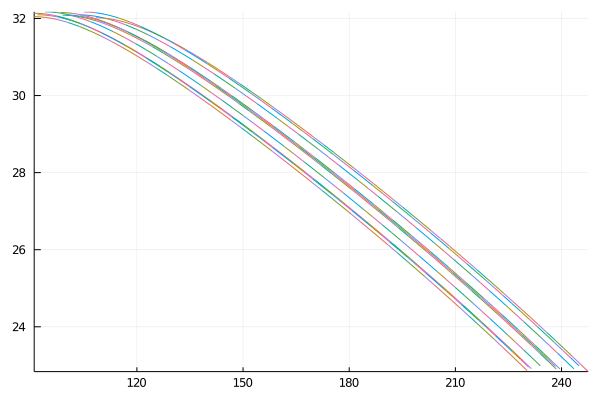

In [8]:
using Plots
fig = plot()
for simulation in simulations
    plot!(fig, simulation, vars=(1, 2), fmt=:png)
end
fig